# Capstone Week 5
---

# Index
- [Capstone Objectives](#Capstone-Objectives)
- [Read in Data](#Read-in-Data)
    - [Merge 2018 and 2019](#Merge-2018-and-2019)
    - [Make advisor and firm dictionary mapper](#Make-advisor-and-firm-dictionary-mapper)
- [EDA](#EDA)
- [Data Cleaning](#Data-Cleaning)
    - [Train-Test-Split](#Train-Test-Split)
- [Missing Data](#Missing-Data)
    - [How big of a problem is missing data?](#How-big-of-a-problem-is-missing-data?)
    - [Three types of missing data](#Three-types-of-missing-data)
    - [Strategies for handling missing data](#Strategies-for-handling-missing-data)
        - [Weight Class Adjustment Example](#Weight-Class-Adjustment-Example)
    - [Imputation Strategies](#Imputation-Strategies)
    - [Missingness Tests](#Missingness-Tests)
    - [MCAR Data](#MCAR-Data)
    - [MAR Data](#MAR-Data)
    - [NMAR Data](#NMAR-Data)
    - [Missing data workflow](#Missing-data-workflow)
    - [Custom Cleaning Functions](#Custom-Cleaning-Functions)
    - [Create Cleaning Pipeline](#Create-Cleaning-Pipeline)
- [Model building](#Model-building)
- [Make predictions](#Make-predictions)
- [Feature Engineering](#Feature-Engineering)
    - [Variable Inflation Factor (VIF)](#Variable-Inflation-Factor-(VIF))
- [Residuals](#Residuals)
- [Classification](#Classification)
- [Model Interpretation](#Model-Interpretation)

# Capstone Objectives
- Assist sales and marketing by improving their targeting
- Predict sales for 2019 using the data for 2018
- Estimate the probability of adding a new fund in 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

pd.set_option('display.max_columns', 50)

[Back to Top](#Index)
# Read in Data

In [2]:
df18 = pd.read_excel("../../capstone-run2/Transaction Data.xlsx", sheet_name='Transactions18')
df19 = pd.read_excel("../../capstone-run2/Transaction Data.xlsx", sheet_name='Transactions19')
firm = pd.read_excel("../../capstone-run2/Firm Information.xlsx", sheet_name="Rep summary")

## Merge 2018 and 2019

In [3]:
df = pd.merge(
    df18,
    df19,
    on='CONTACT_ID',
    suffixes=['_2018', '_2019']
)
df.head()

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date_2018,sales_12M_2019,new_Fund_added_12M_2019,refresh_date_2019
0,0047433,21.0,38.0,NaN,1.0,5.0,5.0,NaN,1.0,2.0,2.0,NaN,1.0,8.0,1.0,237480.11,250.0,19682.0,-1496.745,-102496.165,NaN,-47342.32,284737.93,84.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122866.04,114614.07,0.0,0.0,2018-12-31,18633.105,NaN,2019-12-31
1,4461312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,19629.00,NaN,NaN,NaN,NaN,NaN,0.00,19629.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19629.00,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31
2,4491079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1758.70,NaN,NaN,NaN,NaN,NaN,0.00,1758.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1758.70,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31
3,0107408,20.0,NaN,2.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,57943.00,5459.0,52484.0,NaN,NaN,1.0,0.00,0.00,57943.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57943.00,0.00,0.0,0.0,2018-12-31,93212.000,1.0,2019-12-31
4,85101140503769936458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8573.59,NaN,NaN,NaN,NaN,NaN,-8573.59,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8573.59,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31


## Make advisor and firm dictionary mapper

In [4]:
adviser_lookup = {
    idx: contact_id 
        for idx, contact_id in enumerate(df['CONTACT_ID'])
}

In [5]:
adviser_lookup[10]

'85102150753418532658'

In [6]:
firm_lookup = {idx: contact_id for idx, contact_id in enumerate(firm['Contact ID'])}

In [7]:
firm_lookup[10]

'0001806'

[Back to Top](#Index)
# EDA

In [8]:
# !conda install -yc conda-forge pandas-profiling

In [9]:
# from pandas_profiling import ProfileReport

# missing_diagrams = {
#     'heatmap': True, 'dendrogram': True, 'matrix':True, 'bar': True,
# }

# profile = ProfileReport(df, title='Nuveen Profile Report', missing_diagrams=missing_diagrams)

# profile.to_file(output_file="nuveen_profiling.html")

[Back to Top](#Index)
# Data Cleaning

In [10]:
# make a variable to keep all of the columns we want to drop
COLS_TO_DROP = [
    'refresh_date_2019', 'refresh_date_2018', 'CONTACT_ID',
    'Contact ID', 'CustomerID', 'Firm ID', 'Office ID',
    'Channel','Sub channel', 'Firm name'
]

COLS_TO_KEEP = [
    'no_of_sales_12M_1', 'no_of_Redemption_12M_1', 'no_of_sales_12M_10K',
    'no_of_Redemption_12M_10K', 'no_of_funds_sold_12M_1',
    'no_of_funds_redeemed_12M_1', 'no_of_fund_sales_12M_10K',
    'no_of_funds_Redemption_12M_10K', 'no_of_assetclass_sold_12M_1',
    'no_of_assetclass_redeemed_12M_1', 'no_of_assetclass_sales_12M_10K',
    'no_of_assetclass_Redemption_12M_10K', 'No_of_fund_curr',
    'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M_2018',
    'redemption_curr', 'redemption_12M', 'new_Fund_added_12M_2018',
    'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
    'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
    'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
    'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
    'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT', 
]

FIRM_COLS = ['Contact ID', 'Channel','Sub channel',]

# Make `Firm` data pipeline

In [11]:
df = pd.merge(df, firm, left_on="CONTACT_ID", right_on='Contact ID')
df.head(1)

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date_2018,sales_12M_2019,new_Fund_added_12M_2019,refresh_date_2019,Contact ID,CustomerID,Firm ID,Office ID,Channel,Sub channel,Firm name
0,0047433,21.0,38.0,NaN,1.0,5.0,5.0,NaN,1.0,2.0,2.0,NaN,1.0,8.0,1.0,237480.11,250.0,19682.0,-1496.745,-102496.165,NaN,-47342.32,284737.93,84.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122866.04,114614.07,0.0,0.0,2018-12-31,18633.105,NaN,2019-12-31,0047433,240,1688552,85101152293608716061,National Broker-Dealer,NACS,"UBS Financial Services, Inc."


In [12]:
X = df.drop(['sales_12M_2019', 'new_Fund_added_12M_2019'], axis=1)
y_reg = df['sales_12M_2019']
y_cl = df['new_Fund_added_12M_2019']

## Train-Test-Split

In [13]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.3, random_state=24
)
y_train_cl, y_test_cl = y_cl[y_train_reg.index], y_cl[y_test_reg.index]

[Back to Top](#Index)
# Missing Data

Up to this point we haven't put much thought into dealing with missing data. Missing data is EVERYWHERE and it's important to know how to do data science with missing data. It can significantly undermine our results!

### How big of a problem is missing data?

This is difficult question because we only see what we observe. We can use simulated data to help answer this question, but we cannot quantify the impact of missing data in our real data projects.

See this resource: https://github.com/matthewbrems/jupytercon-missing-data-2018

### Three types of missing data

1. **MCAR**: Missing Completely at Random
    - Some intern spills their coffee on your surveys in random order
    - Flip coin of missingness
    
    
2. **MAR**: Missing at Random
    - I adminster a survey about income. Those who are female are less likely to respond to the question about income.
    - Missing data is conditional on data have observed.


3. **NMAR**: Not Missing at Random (Worst type!)
    - I adminster a survey that includes a question about income. Those who have lower incomes are less likely to respond to the question about income.
    - Data of interest are systematically different for respondents and nonrespondents
    - Whether the data are missing or not depends on the value of the unobserved value itself!

[Back to Top](#Index)
### Strategies for handling missing data
1. **Avoid it** (best option, if possible)
    - Use sound design when collecting data
    - Improve survey questioning and design
    - Drop all rows with _any_ missing value
    
    
2. **Ignore it** (second best option, if possible): 
    - Assume your respondents are close enough to the sample of non-respondents
    - Drop any observation with _any_ missing value
    
    
3. **Account for it** (most common):
    - Weight class adjustments
    - Determine why data are missing
    - Employ a strategy for accounting for missing data

[Back to Top](#Index)
#### Weight Class Adjustment Example

I'm estimating job satisfaction among two departments: finance and accounting. Both departments are the same size (A: 50%, F: 50%).

$$W_{finance} = \frac{true\;proportion}{proportion\;of\;responses} = \frac{0.50}{0.25} = 2$$
<br>
$$W_{accounting} = \frac{true\;proportion}{proportion\;of\;responses} = \frac{0.50}{0.75} = \frac{2}{3}$$

[Back to Top](#Index)
### Imputation Strategies

1. Deductive Imputation: use logical relationships to fill in value **VALID**

    - Respondent says the were not victim of crime, but left "victim of a violent crime" question blank.
    - If someone has 2 children in year 1, `NaN` children in year 2, and 2 children in year 3, we can _probably_ impute that in year 2 they still had 2 children.
    - PRO: Valid method, requires minimal "inference"
    - CON: Time consuming and requires specific coding


2. Mean/Median/Mode: use measure central tendency to fill value **INVALID**

     - PRO: Easy to implement
     - CON: Significantly distorts histogram (underestimates variance) and results will look more precise than they really are
     

3. Regression Imputation: replace missing based on predicted value from regression line **INVALID**

    - PRO: Easy to understand
    - CON: Distorts distribution and underestimates variance still because there is no randomness in the prediction
    
    
4. Stochastic Regression Imputation:

    - Replace missing with predicted value from regression line plus random draw from normal distribution `N(0, s)`, where `s` is estimataed from model residuals **INVALID**
    
    - PRO: Easy to understand and better than just regression technique
    - CON: Still under estimate variance because selecting single point from normal distribution of error
    
    
5. Multiply Stochastic Regression Imputation: pull multiple values from distribution. Replace missing with predicted value from line with random error.

    - PRO: Better than number 4
    - CON: All `Beta` coefficients are constant, so still not credible
    
    
6. Proper Multiply Stochastic Regression Imputation: Called Multiple Imputation by Chained Equations [(MICE)](https://stats.stackexchange.com/questions/421545/multiple-imputation-by-chained-equations-mice-explained)

    - Create `n` copies of your data set (let's say, 10)
    - For each dataset:
        - Generate coefficients for your regression model
            - For each missing value:
                - Replace `NaN` with a value predicted from a regression
            - Do your "final analysis" or generate your final prediction
    - Aggregate your analysis/predictions across all data sets so you have one complete analysis
    - These predictions were created by properly estimating the variance in your data
    - PRO: Very good method, **VALID**
    - CON: Takes more effort to implement (`fancyimpute` or `mice` in R)

[Back to Top](#Index)
### Missingness Tests

1. Little's Test for MCAR
    - $H_0 : MCAR$
    - $H_A : MAR$
    - There is no test for NMAR!
2. Split your data into "observed" and "unobserved" and compare them
    - Split missing `income` and observed `income` sets. Do the other variables have the same distributions?
3. Think about missing data process. Can you come up with a reasonable answer based on how missing data came about?

[Back to Top](#Index)
### MCAR Data

Use any of the methods we previously discussed:
- Deductive imputation
- Proper imputation
- Stochastic Regression Imputation
- Complete-Case Removal (unbiased, but variance will be higher because our sample size is smaller!)

### MAR Data

Use one of the following methods:
- Deductive imputation
- Proper imputation
- Stochastic Regression Imputation

### NMAR Data

Use one of the following methods:
- Deductive imputation
- Advanced methods: selection models and pattern mixture models

[Back to Top](#Index)
### Missing data workflow
1. How much missing data do I have?
2. For each variable, estimate the type of missing data
3. What is the best method for handling missing values?

## Custom Cleaning Functions

Let's create functions that do some basic housekeeping

In [14]:
def extract_columns(df):
    '''extract out columns not listed in COLS_TO_DROP variable'''
    cols_to_keep = [col for col in df.columns if col not in COLS_TO_DROP]
    return df.loc[:, cols_to_keep].copy()


def fillna_values(df):
    '''fill nan values with zero'''
    if isinstance(df, type(pd.Series(dtype='float64'))):
        return df.fillna(0)
    num_df = df.select_dtypes(include=['number']).fillna(0)
    non_num_df = df.select_dtypes(exclude=['number'])
    return pd.concat([num_df, non_num_df], axis=1)


def negative_to_zero(df):
    if isinstance(df, type(pd.Series(dtype='float64'))):
        return df.apply(lambda x: max(0, x))
    else:
        return df.select_dtypes(include='number').clip(lower=0)

[Back to Top](#Index)
## Create Cleaning Pipeline

- Pipeline for target variable
- Pipeline for features

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.preprocessing import StandardScaler

In [16]:
extract_columns_trans = FunctionTransformer(extract_columns)
fillna_values_trans = FunctionTransformer(fillna_values)
negative_to_zero_trans = FunctionTransformer(negative_to_zero)

Make pipeline for regression target variable

In [17]:
targ_pipe_reg = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('negative_to_zero_trans', negative_to_zero_trans),
    ('PowerTransformer', PowerTransformer(standardize=False))
])

y_train_reg = pd.Series(
    targ_pipe_reg.fit_transform(y_train_reg.to_frame()).squeeze(),
    index=y_train_reg.index
)
y_test_reg = pd.Series(
    targ_pipe_reg.transform(y_test_reg.to_frame()).squeeze(),
    index=y_test_reg.index
)

<AxesSubplot:>

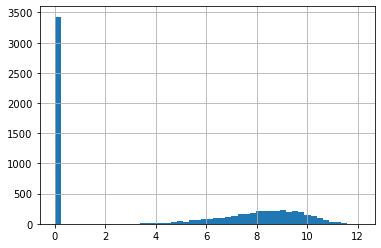

In [18]:
y_train_reg.hist(bins=50)

Transform the classification target

In [19]:
from sklearn.preprocessing import Binarizer

targ_pipe_cl = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('Binarizer', Binarizer(threshold=0))
])

y_train_cl = pd.Series(
    targ_pipe_cl
        .fit_transform(y_train_cl.to_frame())
        .reshape(-1), index=y_train_cl.index)

y_test_cl = pd.Series(
    targ_pipe_cl
        .transform(y_test_cl.to_frame())
        .reshape(-1), index=y_test_cl.index)
y_test_cl

2052    0.0
2758    1.0
4334    0.0
9047    1.0
7001    0.0
       ... 
3541    1.0
785     0.0
7614    0.0
9577    0.0
1086    0.0
Length: 3002, dtype: float64

Create the pipeline for the features

In [20]:
X_train.head()

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date_2018,refresh_date_2019,Contact ID,CustomerID,Firm ID,Office ID,Channel,Sub channel,Firm name
1666,85202120645303133068,NaN,15.0,NaN,3.0,NaN,2.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,1.0,124813.230,NaN,NaN,NaN,-80270.75,NaN,132498.52,0.00,-7685.290,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,124813.230,0.0,0.0,0.0,2018-12-31,2019-12-31,85202120645303133068,9447,0004945,85102120645289553720,Independent Dealer,IBD,Thrivent Investment Management Inc.
4027,0071729,1.0,5.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,3.0,1.0,1.0,15.0,5.0,2029880.100,NaN,24744.70,NaN,-26803.69,NaN,125269.73,1234750.50,304631.170,0.0,-5181.42,0.0,19375.82,351034.30,0.0,0.0,811281.18,0.0,1054358.720,152460.5,0.0,11779.7,2018-12-31,2019-12-31,0071729,384,1567450,15674500229,National Broker-Dealer,NACS,Merrill Lynch
241,85102113714852777311,117.0,49.0,NaN,3.0,12.0,12.0,NaN,2.0,3.0,3.0,NaN,1.0,9.0,2.0,1802715.870,10185.14,123504.19,NaN,-311243.84,1.0,21552.80,-39977.82,201.510,0.0,0.00,0.0,0.00,1820939.38,0.0,0.0,0.00,0.0,1802715.870,0.0,0.0,0.0,2018-12-31,2019-12-31,85102113714852777311,7910,1574035,10751172744618069510,Independent Dealer,IBD,"Securian Financial Services, Inc."
8902,4405242,22.0,14.0,10.0,2.0,4.0,4.0,2.0,2.0,3.0,3.0,2.0,2.0,9.0,3.0,1090937.840,20681.42,363298.62,-361.24,-44328.78,NaN,118712.89,690481.14,-84669.100,0.0,366412.91,0.0,0.00,0.00,0.0,0.0,0.00,0.0,1090937.840,0.0,0.0,0.0,2018-12-31,2019-12-31,4405242,3953,85201112683918276481,85102151343851628812,Independent Dealer,NACS,Wells Fargo Banking & Investment Services
1326,85202112313393367488,25.0,27.0,3.0,NaN,5.0,4.0,3.0,NaN,3.0,3.0,2.0,NaN,3.0,2.0,77502.185,NaN,68556.42,NaN,-2723.25,1.0,35262.35,2043.14,40196.695,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,77502.185,0.0,0.0,0.0,2018-12-31,2019-12-31,85202112313393367488,9378,0001194,85201112093802596437,Independent Dealer,IBD,"Ameriprise Financial Services, Inc."


In [21]:
feat_pipe = Pipeline([
    ('extract_columns_trans', extract_columns_trans),
    ('fillna_values_trans', fillna_values_trans),
    ('StandardScaler', StandardScaler()),
])

X_train_prepared = feat_pipe.fit(X_train).transform(X_train)
X_test_prepared = feat_pipe.transform(X_test)

**TRANSFORM** Test set

In [22]:
X_train_prepared = pd.DataFrame(
    X_train_prepared,
    index=X_train.index,
    columns=COLS_TO_KEEP
)

X_test_prepared = pd.DataFrame(
    feat_pipe.transform(X_test),
    index=X_test.index,
    columns=COLS_TO_KEEP
)

In [23]:
X_test_prepared

,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT
2052,-0.199371,-0.093252,-0.207843,-0.089515,-0.573977,-0.221485,-0.430359,0.301512,-0.784078,0.083188,-0.536570,0.782602,-0.373415,0.063655,-0.258339,-0.085083,-0.151783,-0.609095,0.095688,-0.415778,-0.518275,-0.078960,-0.058282,-0.012892,-0.022410,6.269968,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.259043,-0.056194,-0.01714,-0.070413
2758,-0.159635,-0.048462,-0.207843,-0.205862,-0.153081,0.591014,-0.430359,-0.442232,0.201190,1.035094,-0.536570,-0.561332,-0.693256,-0.888855,-0.102691,-0.083568,-0.151026,0.091395,0.146089,-0.415778,-0.039400,-0.078960,-0.065878,-0.012892,-0.022410,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.073601,-0.056194,-0.01714,-0.070413
4334,-0.199371,-0.097731,-0.207843,-0.205862,-0.573977,-0.627735,-0.430359,-0.442232,-0.784078,-0.868718,-0.536570,-0.561332,-0.373415,0.063655,-0.093857,-0.085083,-0.151783,0.091395,0.155620,-0.415778,-0.027182,-0.079302,-0.040421,-0.012892,-0.018591,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.063076,-0.056194,-0.01714,-0.070413
9047,0.118515,0.050076,-0.207843,-0.205862,0.688712,0.591014,-0.430359,-0.442232,1.186457,1.035094,-0.536570,-0.561332,-0.053573,0.063655,-0.096939,-0.073236,-0.133039,0.091103,0.144632,-0.415778,-0.014956,-0.085461,-0.058935,-0.012892,-0.022410,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.066749,-0.056194,-0.01714,-0.070413
7001,0.009242,0.171009,-0.115750,0.259524,-0.153081,1.403513,0.318971,1.789002,0.201190,1.035094,0.858232,2.126536,0.266268,0.063655,-0.098609,-0.085083,-0.077280,0.070873,-0.189406,-0.415778,-0.037940,-0.079761,-0.037229,-0.012892,-0.022410,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.068738,-0.056194,-0.01714,-0.070413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3541,0.376797,0.112782,1.357732,0.375870,1.109608,0.591014,1.817630,1.789002,2.171725,1.987000,3.647837,3.470469,0.905951,1.016164,0.240511,-0.085083,0.168188,-0.352809,-0.123876,1.289958,-0.098124,-0.029076,-0.138181,-0.012892,4.647680,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,0.335295,-0.056194,-0.01714,-0.070413
785,-0.199371,-0.097731,-0.207843,-0.205862,-0.573977,-0.627735,-0.430359,-0.442232,-0.784078,-0.868718,-0.536570,-0.561332,-0.693256,-0.888855,-0.097262,-0.085083,-0.151783,0.091395,0.155620,-0.415778,-0.029158,-0.078960,-0.058282,-0.012892,-0.022410,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.067133,-0.056194,-0.01714,-0.070413
7614,-0.199371,-0.097731,-0.207843,-0.205862,-0.573977,-0.627735,-0.430359,-0.442232,-0.784078,-0.868718,-0.536570,-0.561332,-0.373415,0.063655,-0.085369,-0.085083,-0.151783,0.091395,0.155620,-0.415778,-0.029158,-0.065118,-0.058282,-0.012892,-0.022410,-0.042489,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.052964,-0.056194,-0.01714,-0.070413
9577,-0.000692,-0.084294,-0.115750,-0.205862,0.688712,-0.221485,0.318971,-0.442232,1.186457,0.083188,0.858232,-0.561332,0.266268,1.016164,-0.065484,-0.079434,-0.123801,0.091395,0.155591,-0.415778,0.018326,-0.065245,-0.058282,-0.012892,-0.023818,-0.038570,-0.03771,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.040609,-0.037756,-

[Back to Top](#Index)
# Model building
- Evaluate baseline model
- Create new models
- Create evaluation function and cross validate

### Decision Tree Regressor

In [53]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [50]:
dtr = DecisionTreeRegressor()

In [51]:
dtr.fit(X_train_prepared, y_train_reg)

DecisionTreeRegressor()

In [52]:
dtr.predict(X_test_prepared)

array([0.        , 8.56175985, 0.        , ..., 0.        , 8.67028762,
       8.63036001])

In [54]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_prepared, y_train_cl)

DecisionTreeClassifier()

In [55]:
dtc.predict(X_test_prepared)

array([0., 0., 1., ..., 1., 0., 0.])

In [76]:
import seaborn as sns

<AxesSubplot:>

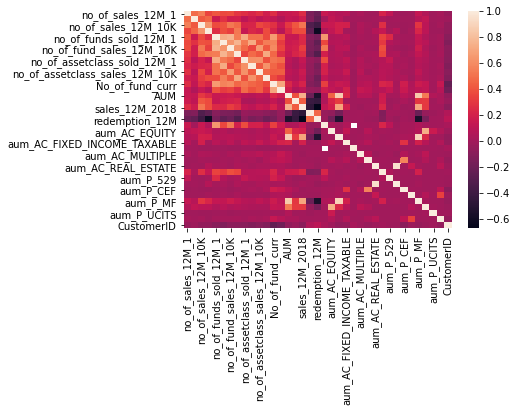

In [77]:
sns.heatmap(X_train.corr())

|--- feature_8 <= 0.69
|   |--- feature_14 <= -0.10
|   |   |--- class: 0.0
|   |--- feature_14 >  -0.10
|   |   |--- feature_14 <= -0.10
|   |   |   |--- class: 1.0
|   |   |--- feature_14 >  -0.10
|   |   |   |--- class: 0.0
|--- feature_8 >  0.69
|   |--- class: 0.0



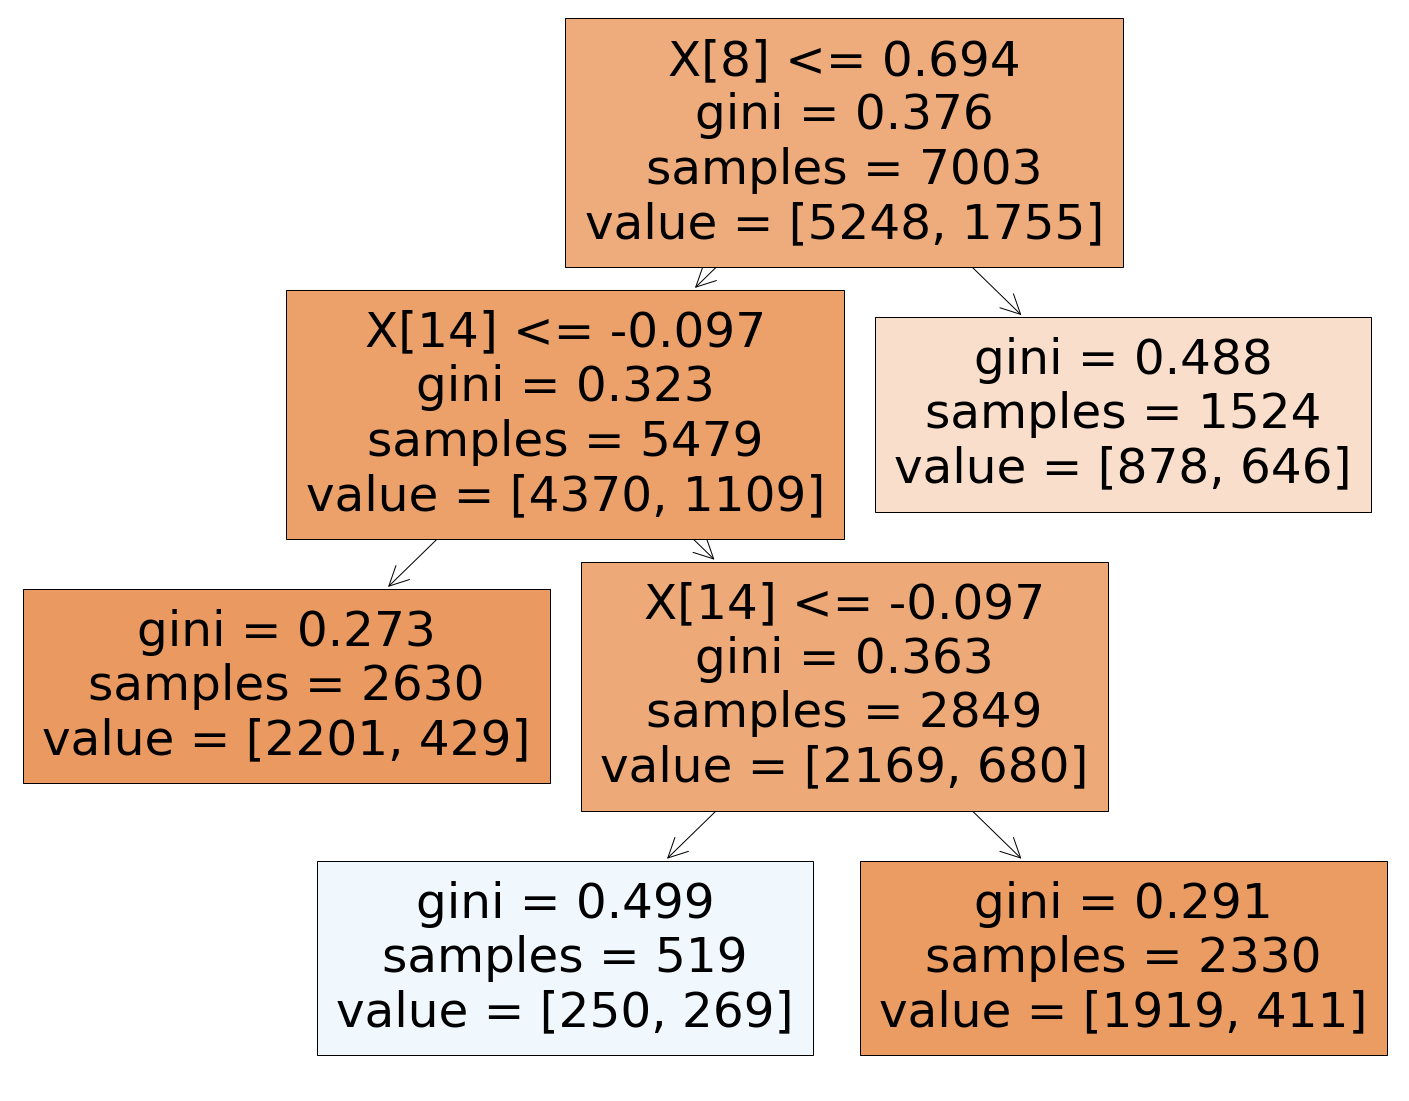

In [74]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_leaf_nodes=4, random_state=0)

# Train Decision Tree Classifer
model = clf.fit(X_train_prepared,y_train_cl)

#Predict the response for test dataset
y_pred = model.predict(X_test_prepared)


from sklearn import tree
text_representation = tree.export_text(clf)
print(text_representation)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,filled=True)

In [57]:
X_train_prepared2 = X_train_prepared.copy()

In [58]:
X_train_prepared2['dt_result'] = dtc.predict(X_train_prepared)

In [62]:
for_next_model = X_train_prepared2[X_train_prepared2['dt_result']==1].index

In [63]:
y_train_reg2 = y_train_reg.copy()

In [64]:
y_train_reg2.loc[for_next_model]

9821     6.796512
8119    10.110455
3075    -0.000000
3562     8.296384
9513     6.317436
          ...    
4379    -0.000000
7418     7.149293
9862     7.277601
8576     9.373173
7563     7.691529
Length: 1922, dtype: float64

In [65]:
X_train_prepared.shape

(7003, 36)

In [71]:
X_train['refresh_date_2018']

1666   2018-12-31
4027   2018-12-31
241    2018-12-31
8902   2018-12-31
1326   2018-12-31
          ...    
6500   2018-12-31
5249   2018-12-31
3473   2018-12-31
8535   2018-12-31
899    2018-12-31
Name: refresh_date_2018, Length: 7003, dtype: datetime64[ns]

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA, TruncatedSVD
import xgboost as xgb

In [25]:
lr = LinearRegression()
lr.fit(X_train_prepared, y_train_reg)

LinearRegression()

In [26]:
from sklearn.model_selection import cross_validate

In [27]:
-cross_validate(
    lr, 
    X_train_prepared, 
    y_train_reg, 
    cv=3, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
)['test_score']

array([3.32515627e+00, 2.45976350e+10, 3.33027277e+00])

Make a plot of predictions vs actual

In [28]:
y_test_reg_preds = lr.predict(X_test_prepared)

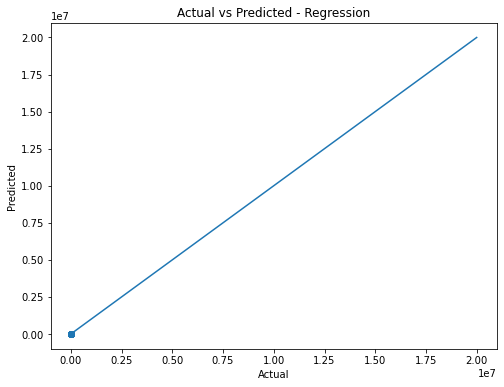

In [29]:
fig, axes = plt.subplots(figsize=(8, 6))

axes.scatter(x=y_test_reg, y=y_test_reg_preds)

axes.plot([0, 20000000], [0,20000000])
axes.set_title("Actual vs Predicted - Regression")
axes.set_xlabel("Actual")
axes.set_ylabel("Predicted");

In [30]:
def evaluate_model(model, X, y):
    print("Cross Validation Scores:")
    print(-cross_validate(model, X, y, scoring='neg_root_mean_squared_error')['test_score'])
    print('-'*55)
    preds = model.predict(X)
    lim = max(preds.max(), y.max())
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.scatter(x=y, y=preds, alpha=0.4)
    ax.plot([0, lim], [0, lim])
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])
    ax.set_title("Actual vs Predicted - Regression")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted");

Cross Validation Scores:
[ 3.20041514  3.20295751  3.4357037   3.31322157 18.41327458]
-------------------------------------------------------


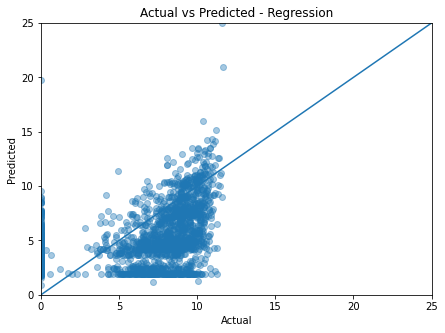

In [31]:
evaluate_model(lr, X_test_prepared, y_test_reg)

## Make function to output deciles

In [32]:
def output_deciles(model, X, y):
    results = pd.DataFrame(model.predict(X), index=X.index, columns=['predictions'])
    results['actual'] = y.values
    results['deciles'] = pd.qcut(results['predictions'], 10, labels=False)
    results['contact_id'] = results.index.map(adviser_lookup)
    return results

In [33]:
regression_deciles = output_deciles(lr, X_test_prepared, y_test_reg)

In [34]:
regression_deciles.groupby('deciles')[['actual']].mean()

,actual
deciles,
0,2.724011
1,0.597896
2,0.793413
3,1.136431
4,2.009706
5,4.049000
6,5.781880
7,6.640869
8,7.895667


In [79]:
from sklearn.feature_selection import RFE

In [80]:
rfe = RFE(lr, n_features_to_select=10)

In [81]:
rfe.fit(X_train_prepared, y_train_reg)

RFE(estimator=LinearRegression(), n_features_to_select=10)

In [83]:
X_train_prepared.columns[rfe.support_]

Index(['no_of_funds_redeemed_12M_1', 'no_of_funds_Redemption_12M_10K',
       'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
       'no_of_assetclass_sales_12M_10K', 'No_of_asset_curr', 'sales_curr',
       'sales_12M_2018', 'aum_AC_FIXED_INCOME_MUNI', 'aum_P_MF'],
      dtype='object')

In [84]:
rfe.predict(X_test_prepared)

array([2.59404615, 4.73791849, 2.05745725, ..., 2.0579428 , 6.83610796,
       4.90676784])

In [92]:
for feat, imp in zip(X_train_prepared.columns,dtr.feature_importances_):
    print(sorted(feat, imp, lambda x: x[0]))


TypeError: sorted expected 1 argument, got 3

In [ ]:
pd.qcut()

In [78]:
X_train_prepared

,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT
1666,-0.199371,-0.030546,-0.207843,0.143178,-0.573977,0.184764,-0.430359,0.301512,-0.784078,0.083188,-0.536570,0.782602,-0.373415,0.063655,-0.061582,-0.085083,-0.151783,0.091395,0.048131,-0.415778,0.060466,-0.078960,-0.073437,-0.012892,-0.022410,-0.042489,-0.037710,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.024624,-0.056194,-0.01714,-0.070413
4027,-0.189437,-0.075336,-0.115750,-0.089515,-0.153081,0.997264,0.318971,0.301512,0.201190,1.987000,0.858232,0.782602,4.104365,3.873693,0.483007,-0.085083,-0.129390,0.091395,0.119728,-0.415778,0.055576,0.331867,0.542411,-0.012892,-0.043019,-0.042489,0.843747,0.592872,-0.076091,-0.030313,2.665173,-0.019128,0.291963,0.028260,-0.01714,0.053316
241,0.962899,0.121740,-0.207843,0.143178,4.476778,4.247261,-0.430359,1.045257,2.171725,1.987000,-0.536570,0.782602,2.185316,1.016164,0.418069,-0.032015,-0.040016,0.091395,-0.261162,0.437090,-0.014580,-0.092261,-0.057885,-0.012892,-0.022410,-0.042489,-0.037710,3.247157,-0.076091,-0.030313,-0.094052,-0.019128,0.546840,-0.056194,-0.01714,-0.070413
8902,0.019176,-0.035025,0.713083,0.026831,1.109608,0.997264,1.068300,1.045257,2.171725,1.987000,2.253035,2.126536,2.185316,1.968674,0.214598,0.022675,0.176991,0.089568,0.096260,-0.415778,0.051141,0.150777,-0.225239,-0.012892,1.434982,-0.042489,-0.037710,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,0.304421,-0.056194,-0.01714,-0.070413
1326,0.048977,0.023202,0.068435,-0.205862,1.530505,0.997264,1.817630,-0.442232,2.171725,1.987000,2.253035,-0.561332,0.266268,1.016164,-0.075106,-0.085083,-0.089742,0.091395,0.151973,0.437090,-0.005306,-0.078280,0.020980,-0.012892,-0.022410,-0.042489,-0.037710,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.040737,-0.056194,-0.01714,-0.070413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6500,-0.199371,-0.097731,-0.207843,-0.205862,-0.573977,-0.627735,-0.430359,-0.442232,-0.784078,-0.868718,-0.536570,-0.561332,-0.053573,0.063655,-0.051613,-0.085083,-0.151783,0.091395,0.155620,-0.415778,0.078855,-0.078960,-0.058282,-0.012892,-0.022410,-0.042489,-0.037710,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.012747,-0.056194,-0.01714,-0.070413
5249,-0.199371,-0.097731,-0.207843,-0.205862,-0.573977,-0.627735,-0.430359,-0.442232,-0.784078,-0.868718,-0.536570,-0.561332,-0.693256,-0.888855,-0.114427,-0.085083,-0.151783,0.091395,0.155620,-0.415778,-0.034074,-0.096521,-0.058282,-0.012892,-0.022410,-0.042489,-0.037710,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.087584,-0.056194,-0.01714,-0.070413
3473,-0.050362,-0.075336,-0.207843,-0.205862,-0.153081,-0.221485,-0.430359,-0.442232,0.201190,0.083188,-0.536570,-0.561332,-0.373415,0.063655,0.015651,0.547239,-0.143782,0.071830,0.152741,-0.415778,-0.029158,0.052461,-0.058282,-0.012892,-0.022410,-0.042489,-0.037710,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.069168,0.165917,-0.01714,-0.070413
8535,-0.189437,-0.061899,-0.207843,-0.205862,-0.153081,-0.221485,-0.430359,-0.442232,0.201190,0.083188,-0.536570,-0.561332,-0.373415,0.063655,-0.057470,-0.085083,-0.148434,0.053336,0.130156,0.437090,0.062495,-0.078960,-0.050985,-0.012892,-0.022410,-0.042489,-0.037710,-0.041009,-0.076091,-0.030313,-0.094052,-0.019128,-0.019724,-0.056194,-0.01714,-0.070413


[Back to Top](#Index)
## Residual Analysis

In [35]:
y_test_reg_preds = lr.predict(X_test_prepared)

In [36]:
y_test_reg_preds

array([2.16753409, 4.67150138, 2.02458976, ..., 2.02571891, 6.66686271,
       4.89807532])

In [37]:
# get the residuals
residuals = y_test_reg_preds - y_test_reg

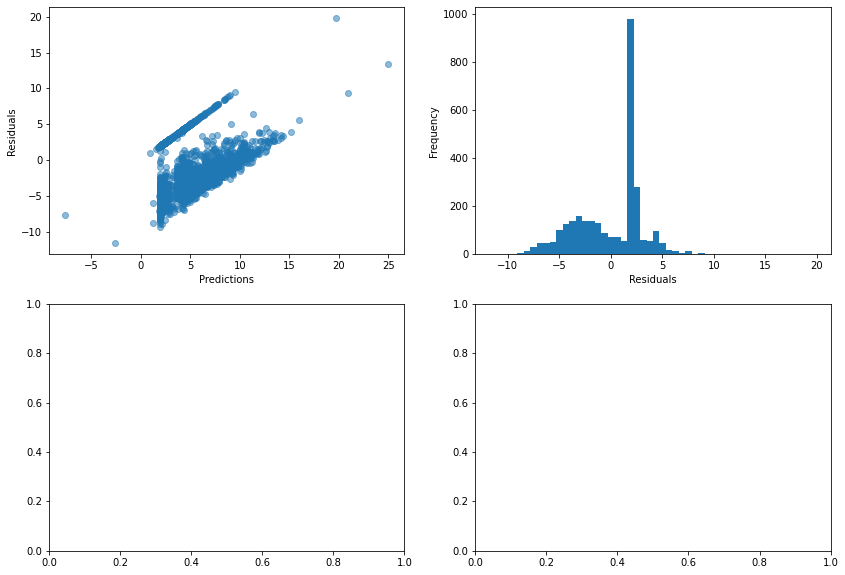

In [38]:
# plot predictions vs residuals
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

# plot scatter plot on upper left plot
axes[0,0].scatter(x=y_test_reg_preds, y=residuals, alpha=0.5)
axes[0,0].set(xlabel='Predictions', ylabel='Residuals')

# plot a hist on upper right plot
axes[0,1].hist(residuals, bins=50)
axes[0,1].set(xlabel='Residuals', ylabel='Frequency');

In [39]:
from statsmodels.api import qqplot

In [41]:
img = qqplot(residuals, fit=True, line='r', ax=axes[1,0])

In [42]:
plt.savefig('qq_plot.png')

<Figure size 432x288 with 0 Axes>

In [43]:
ls -la

total 528
drwxr-xr-x   5 carletonsmith  staff     160 Aug 13 07:08 ./
drwxr-xr-x  16 carletonsmith  staff     512 Aug 13 06:46 ../
drwxr-xr-x   3 carletonsmith  staff      96 Aug 13 06:47 .ipynb_checkpoints/
-rw-r--r--   1 carletonsmith  staff  264254 Aug 13 07:06 5-Open-OH.ipynb
-rw-r--r--   1 carletonsmith  staff    1257 Aug 13 07:08 qq_plot.png


In [45]:
pd.Series(y_test_reg_preds).to_csv('regression_results.csv')

In [46]:
ls -la

total 584
drwxr-xr-x   6 carletonsmith  staff     192 Aug 13 07:10 ./
drwxr-xr-x  16 carletonsmith  staff     512 Aug 13 06:46 ../
drwxr-xr-x   3 carletonsmith  staff      96 Aug 13 06:47 .ipynb_checkpoints/
-rw-r--r--   1 carletonsmith  staff  219161 Aug 13 07:10 5-Open-OH.ipynb
-rw-r--r--   1 carletonsmith  staff    1257 Aug 13 07:08 qq_plot.png
-rw-r--r--   1 carletonsmith  staff   69691 Aug 13 07:10 regression_results.csv


In [48]:
X_train

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date_2018,refresh_date_2019,Contact ID,CustomerID,Firm ID,Office ID,Channel,Sub channel,Firm name
1666,85202120645303133068,NaN,15.0,NaN,3.0,NaN,2.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,1.0,124813.230,NaN,NaN,NaN,-80270.75,NaN,132498.520,0.00,-7685.290,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,124813.230,0.00,0.0,0.0,2018-12-31,2019-12-31,85202120645303133068,9447,0004945,85102120645289553720,Independent Dealer,IBD,Thrivent Investment Management Inc.
4027,0071729,1.0,5.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,3.0,1.0,1.0,15.0,5.0,2029880.100,NaN,24744.70,NaN,-26803.69,NaN,125269.730,1234750.50,304631.170,0.0,-5181.42,0.0,19375.82,351034.30,0.0,0.0,811281.18,0.0,1054358.720,152460.50,0.0,11779.7,2018-12-31,2019-12-31,0071729,384,1567450,15674500229,National Broker-Dealer,NACS,Merrill Lynch
241,85102113714852777311,117.0,49.0,NaN,3.0,12.0,12.0,NaN,2.0,3.0,3.0,NaN,1.0,9.0,2.0,1802715.870,10185.14,123504.19,NaN,-311243.84,1.0,21552.800,-39977.82,201.510,0.0,0.00,0.0,0.00,1820939.38,0.0,0.0,0.00,0.0,1802715.870,0.00,0.0,0.0,2018-12-31,2019-12-31,85102113714852777311,7910,1574035,10751172744618069510,Independent Dealer,IBD,"Securian Financial Services, Inc."
8902,4405242,22.0,14.0,10.0,2.0,4.0,4.0,2.0,2.0,3.0,3.0,2.0,2.0,9.0,3.0,1090937.840,20681.42,363298.62,-361.240,-44328.78,NaN,118712.890,690481.14,-84669.100,0.0,366412.91,0.0,0.00,0.00,0.0,0.0,0.00,0.0,1090937.840,0.00,0.0,0.0,2018-12-31,2019-12-31,4405242,3953,85201112683918276481,85102151343851628812,Independent Dealer,NACS,Wells Fargo Banking & Investment Services
1326,85202112313393367488,25.0,27.0,3.0,NaN,5.0,4.0,3.0,NaN,3.0,3.0,2.0,NaN,3.0,2.0,77502.185,NaN,68556.42,NaN,-2723.25,1.0,35262.350,2043.14,40196.695,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,77502.185,0.00,0.0,0.0,2018-12-31,2019-12-31,85202112313393367488,9378,0001194,85201112093802596437,Independent Dealer,IBD,"Ameriprise Financial Services, Inc."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6500,85201110265340471308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,159685.970,NaN,NaN,NaN,NaN,NaN,159685.970,0.00,0.000,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,159685.970,0.00,0.0,0.0,2018-12-31,2019-12-31,85201110265340471308,8508,1616752,10751172914014733476,Independent Dealer,IBD,"Voya Financial Advisors, Inc."
5249,85102113715228199443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-60046.960,NaN,NaN,NaN,NaN,NaN,-7266.770,-52780.19,0.000,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,-60046.960,0.00,0.0,0.0,2018-12-31,2019-12-31,85102113715228199443,7912,1471422,14714227615,Independent Dealer,IBD,Edward Jones
3473,4300883,15.0,5.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,394988.300,121357.97,8841.18,-3870.000,-2150.00,NaN,0.000,394988.30,0.000,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,-5976.060,400964.36,0.0,0.0,2018-12-31,2019-12-31,4300883,2139,3001220,85101130274215178411,Independent Dealer,IBD,PNC Investments LLC
8535,0328129,1.0,8.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,139198.975,NaN,3700.81,-7528.145,-19015.82,1.0,135498.165,0.00,3700.810,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,139198.975,0.00,0.0,0.0,2018-12-31,2019-12-31,0328129,1548,1735461,85202160653459015684,Independent Dealer,I

In [ ]:
targ_pipe_reg.named_steps['PowerTransformer'].inverse_transform(y_test_reg_preds.reshape(-1,1)).squeeze()

In [ ]:
# !pip install scikit-plot

In [ ]:
import scikitplot as skplt

In [ ]:
def evaluate_classifier(X, y, model):
    pass
    # print classification report
    # create lift charts
    # create gains charts

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()

In [ ]:
rf.fit(X_train_prepared, y_train_cl)

In [ ]:
y_test_cl_preds = rf.predict_proba(X_test_prepared)

In [ ]:
skplt.metrics.plot_lift_curve(y_test_cl, y_test_cl_preds);

In [ ]:
np.sort(y_test_cl_preds)[:10]

## Make Classifcation Deciles

In [ ]:
def output_deciles_class(model, X, y):
    results = pd.DataFrame(model.predict_proba(X)[:, 1], index=X.index, columns=['predictions'])
    results['actual'] = y.values
    results['deciles'] = pd.qcut(results['predictions'], 10, labels=False)
    results['contact_id'] = results.index.map(adviser_lookup)
    return results

In [ ]:
class_results = output_deciles_class(rf, X_test_prepared, y_test_cl)

In [ ]:
class_results.groupby('deciles')[['actual']].mean()

In [ ]:
df.isnull().sum()